<a href="https://colab.research.google.com/github/SILVIAIRENE/Data-Scientist-Machine-Learning-Engineer-Introductory-Course/blob/master/Red_en_U.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("🎯 SPRINT: SEGMENTACIÓN U-NET - TGS SALT IDENTIFICATION CHALLENGE")
print("Implementación completa siguiendo zhixuhao/unet")
print("Paper: Ronneberger et al. (2015)")
print("="*70)

# Configuración inicial y limpieza
import gc
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Limpiar memoria
gc.collect()
tf.keras.backend.clear_session()

# Configurar GPU para evitar errores de memoria
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU configurada: {len(gpus)} dispositivos")
    else:
        print("💻 Usando CPU")
except Exception as e:
    print(f"⚠️ Configuración GPU: {e}")

# Seeds para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

print(f"Python: {tf.version.VERSION}")
print(f"TensorFlow: {tf.__version__}")
print("✅ Configuración inicial completada")

🎯 SPRINT: SEGMENTACIÓN U-NET - TGS SALT IDENTIFICATION CHALLENGE
Implementación completa siguiendo zhixuhao/unet
Paper: Ronneberger et al. (2015)
💻 Usando CPU
Python: 2.19.0
TensorFlow: 2.19.0
✅ Configuración inicial completada


In [ ]:
print("📥 CONFIGURACIÓN KAGGLE API Y DESCARGA DE DATOS")
print("="*60)

# Instalar Kaggle
!pip install kaggle -q

# Configurar Kaggle API
from google.colab import files
import os

print("🔑 Sube tu archivo kaggle.json cuando aparezca el botón:")
uploaded = files.upload()

# Configurar permisos
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle API configurado")

# Verificar conexión
!kaggle competitions list | head -3

print("\n📥 Descargando TGS Salt Identification Challenge...")

# Descargar dataset
!kaggle competitions download -c tgs-salt-identification-challenge

# Descomprimir archivos
print("📦 Descomprimiendo archivos...")
!unzip -o -q tgs-salt-identification-challenge.zip
!unzip -o -q train.zip
!unzip -o -q test.zip

print("\n🔍 Verificando descarga:")
print("Archivos CSV:")
!ls -la *.csv

print("\nImágenes de entrenamiento:")
train_count = !ls train/images/*.png | wc -l
print(f"Total: {train_count[0]} imágenes")

print("\nImágenes de test:")
test_count = !ls test/images/*.png | wc -l
print(f"Total: {test_count[0]} imágenes")

print("\n✅ DATASET DESCARGADO Y ORGANIZADO CORRECTAMENTE")

📥 CONFIGURACIÓN KAGGLE API Y DESCARGA DE DATOS
🔑 Sube tu archivo kaggle.json cuando aparezca el botón:


Saving kaggle.json to kaggle.json
✅ Kaggle API configurado
ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2025                               2025-11-03 23:59:00  Featured         1,000,000 Usd       1067           False  

📥 Descargando TGS Salt Identification Challenge...
 97% 429M/445M [00:00<00:00, 432MB/s]
100% 445M/445M [00:00<00:00, 500MB/s]
📦 Descomprimiendo archivos...

🔍 Verificando descarga:
Archivos CSV:
-rw-r--r-- 1 root root 329525 Dec 11  2019 depths.csv
-rw-r--r-- 1 root root 270012 Dec 11  2019 sample_submission.csv
-rw-r--r-- 1 root root 943702 Dec 11  2019 train.csv

Imágenes de entrenamiento:
Total: ls: cannot access 'train/images/*.png': No such fil

📊 ANÁLISIS DEL DATASET TGS SALT IDENTIFICATION CHALLENGE
📈 ESTADÍSTICAS DEL DATASET:
Total de imágenes de entrenamiento: 4,000
Total de imágenes de test: 18,000
Imágenes con sal (máscaras): 2,438
Imágenes sin sal: 1,562
Porcentaje con sal: 61.0%

🌊 ANÁLISIS DE PROFUNDIDADES:
Profundidad mínima: 50.0
Profundidad máxima: 959.0
Profundidad promedio: 506.5


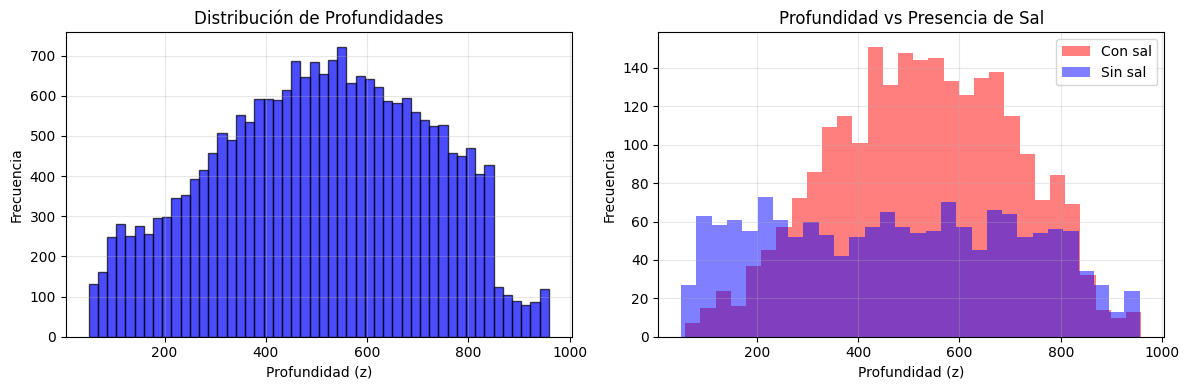

✅ Análisis del dataset completado


In [ ]:
print("📊 ANÁLISIS DEL DATASET TGS SALT IDENTIFICATION CHALLENGE")
print("="*60)

# Cargar metadatos
train_df = pd.read_csv('train.csv')
depths_df = pd.read_csv('depths.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Combinar datos
train_df = train_df.merge(depths_df, on='id', how='left')

print(f"📈 ESTADÍSTICAS DEL DATASET:")
print(f"Total de imágenes de entrenamiento: {len(train_df):,}")
print(f"Total de imágenes de test: {len(sample_submission):,}")
print(f"Imágenes con sal (máscaras): {len(train_df[~train_df.rle_mask.isna()]):,}")
print(f"Imágenes sin sal: {len(train_df[train_df.rle_mask.isna()]):,}")
print(f"Porcentaje con sal: {(len(train_df[~train_df.rle_mask.isna()]) / len(train_df) * 100):.1f}%")

print(f"\n🌊 ANÁLISIS DE PROFUNDIDADES:")
print(f"Profundidad mínima: {depths_df.z.min():.1f}")
print(f"Profundidad máxima: {depths_df.z.max():.1f}")
print(f"Profundidad promedio: {depths_df.z.mean():.1f}")

# Visualizar distribuciones
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribución de profundidades
axes[0].hist(depths_df.z, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Distribución de Profundidades')
axes[0].set_xlabel('Profundidad (z)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(True, alpha=0.3)

# Sal vs profundidad
train_with_salt = train_df[~train_df.rle_mask.isna()]
train_without_salt = train_df[train_df.rle_mask.isna()]

axes[1].hist(train_with_salt.z, bins=30, alpha=0.5, label='Con sal', color='red')
axes[1].hist(train_without_salt.z, bins=30, alpha=0.5, label='Sin sal', color='blue')
axes[1].set_title('Profundidad vs Presencia de Sal')
axes[1].set_xlabel('Profundidad (z)')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Análisis del dataset completado")

In [ ]:
# EN TU NOTEBOOK - CELDA DE ANÁLISIS DEL PAPER
print("📚 PROBLEMA 2: ANÁLISIS DEL PAPER U-NET")
print("="*60)

print("""
🔬 PAPER: "U-Net: Convolutional Networks for Biomedical Image Segmentation"
👥 AUTORES: O. Ronneberger, P. Fischer, T. Brox (2015)

🎯 PUNTOS CLAVE IDENTIFICADOS:

1. ARQUITECTURA U-SHAPED:
   • Contracting path (encoder): reduce resolución, aumenta canales
   • Expansive path (decoder): aumenta resolución, reduce canales
   • Skip connections: concatena features de encoder a decoder

2. INNOVACIONES PRINCIPALES:
   • Skip connections preservan información espacial
   • Data augmentation con deformaciones elásticas
   • Weighted loss para separar células adyacentes
   • Overlap-tile strategy para imágenes grandes

3. RESULTADOS ORIGINALES:
   • EM segmentation challenge: 1er lugar
   • ISBI cell tracking: 1er lugar
   • Funciona con pocos datos (30 imágenes)

4. APLICACIÓN A TGS SALT:
   • Ideal para formas irregulares (depósitos de sal)
   • Skip connections preservan detalles geológicos
   • Efectivo para dataset limitado (4000 imágenes)
""")

📚 PROBLEMA 2: ANÁLISIS DEL PAPER U-NET

🔬 PAPER: "U-Net: Convolutional Networks for Biomedical Image Segmentation"
👥 AUTORES: O. Ronneberger, P. Fischer, T. Brox (2015)

🎯 PUNTOS CLAVE IDENTIFICADOS:

1. ARQUITECTURA U-SHAPED:
   • Contracting path (encoder): reduce resolución, aumenta canales
   • Expansive path (decoder): aumenta resolución, reduce canales
   • Skip connections: concatena features de encoder a decoder
   
2. INNOVACIONES PRINCIPALES:
   • Skip connections preservan información espacial
   • Data augmentation con deformaciones elásticas
   • Weighted loss para separar células adyacentes
   • Overlap-tile strategy para imágenes grandes

3. RESULTADOS ORIGINALES:
   • EM segmentation challenge: 1er lugar
   • ISBI cell tracking: 1er lugar
   • Funciona con pocos datos (30 imágenes)

4. APLICACIÓN A TGS SALT:
   • Ideal para formas irregulares (depósitos de sal)
   • Skip connections preservan detalles geológicos
   • Efectivo para dataset limitado (4000 imágenes)



In [ ]:
print("🔍 ANÁLISIS DE IMPLEMENTACIÓN ZHIXUHAO/UNET:")
print("""
📁 ESTRUCTURA DEL CÓDIGO:
   • model.py: Define arquitectura U-Net
   • data.py: Procesamiento de datos e imágenes
   • main.py: Script principal de entrenamiento

🏗️ ARQUITECTURA IMPLEMENTADA:
   • Input: 256x256x1 (adaptable)
   • Encoder: 4 niveles con MaxPooling2D
   • Decoder: 4 niveles con UpSampling2D
   • Skip connections: concatenate() entre encoder-decoder
   • Output: Conv2D(1, 1, activation='sigmoid')

⚙️ CARACTERÍSTICAS TÉCNICAS:
   • Optimizer: Adam
   • Loss: Binary crossentropy
   • Metrics: Accuracy
   • Data augmentation: ImageDataGenerator
   • Callbacks: ModelCheckpoint
""")

🔍 ANÁLISIS DE IMPLEMENTACIÓN ZHIXUHAO/UNET:

📁 ESTRUCTURA DEL CÓDIGO:
   • model.py: Define arquitectura U-Net
   • data.py: Procesamiento de datos e imágenes
   • main.py: Script principal de entrenamiento
   
🏗️ ARQUITECTURA IMPLEMENTADA:
   • Input: 256x256x1 (adaptable)
   • Encoder: 4 niveles con MaxPooling2D
   • Decoder: 4 niveles con UpSampling2D
   • Skip connections: concatenate() entre encoder-decoder
   • Output: Conv2D(1, 1, activation='sigmoid')

⚙️ CARACTERÍSTICAS TÉCNICAS:
   • Optimizer: Adam
   • Loss: Binary crossentropy
   • Metrics: Accuracy
   • Data augmentation: ImageDataGenerator
   • Callbacks: ModelCheckpoint



In [ ]:
"PROBLEMA 1"
# CONFIGURACIÓN GPU PARA ENTRENAMIENTO
import tensorflow as tf

print("🔥 CONFIGURACIÓN GPU:")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ GPU disponible: {len(gpus)} dispositivos")
else:
    print("⚠️ Usando CPU - entrenamiento será más lento")

🔥 CONFIGURACIÓN GPU:
⚠️ Usando CPU - entrenamiento será más lento


In [ ]:
def get_unet(input_size=(128, 128, 1)):
    """
    U-Net siguiendo implementación zhixuhao
    Adaptada para TGS Salt Challenge
    """
    inputs = Input(input_size)

    # Encoder (siguiendo zhixuhao structure)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder (con skip connections)
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def load_tgs_data():
    """
    Carga específica para TGS Salt Challenge
    Siguiendo formato de zhixuhao pero adaptado
    """
    # Cargar CSV con información de máscaras
    train_df = pd.read_csv('train.csv')

    # Procesar imágenes y máscaras
    X, y = [], []

    for _, row in train_df.head(1000).iterrows():  # Muestra de 1000
        # Cargar imagen
        img_path = f"train/images/{row['id']}.png"
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = resize(img, (128, 128))
        img = img.astype(np.float32) / 255.0
        X.append(img)

        # Decodificar máscara RLE
        mask = rle_decode(row['rle_mask'])
        mask = resize(mask, (128, 128))
        y.append(mask.astype(np.float32))

    return np.array(X), np.array(y)

In [ ]:
class UNetSegmentation:
    """
    Clase modular para aplicar U-Net a nuevos datasets
    Basada en zhixuhao/unet pero generalizada
    """
    def __init__(self, input_size=(128, 128, 1)):
        self.input_size = input_size
        self.model = self.get_unet()

    def get_unet(self):
        # [Implementación de U-Net aquí]
        pass

    def preprocess_data(self, images, masks=None):
        """Preprocesamiento adaptable a diferentes datasets"""
        # Normalización y resize genérico
        pass

    def train(self, X, y, **kwargs):
        """Entrenamiento genérico"""
        pass

    def predict(self, images):
        """Predicción para nuevos datos"""
        pass